###Connecting to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
path_to_folder = "ENPM673/tutorials/"
%cd /content/drive/My\ Drive/{path_to_folder}

/content/drive/My Drive/ENPM673/tutorials


###Importing Dependencies

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.signal import convolve2d
from google.colab.patches import cv2_imshow
from IPython.display import clear_output

# Edge Detection

### Initializing Variables

In [ ]:
# token counts the number of video frames executed
token = 0

# blurry_frames_removed counts the number of video frames removed for being blurry
blurry_frames_removed = 0

### Capturing Video

In [ ]:
#Loading Video
video_capture = cv2.VideoCapture("assets/proj2_v2.mp4")

# Get video properties
frame_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video_capture.get(cv2.CAP_PROP_FPS))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_video.mp4', fourcc, 30, (frame_width, frame_height))

###Loop over each frame to detect edges and corners
1. Convert each frame to Grayscale
2. Apply Variance of Laplacian to remove blurry frames
3. Segment out the background and keep only the white region
4. Detect edges using Canny Edge Detector
5. Extract straight lines in the image using cv2.HoughLinesP( )
6. Calculate the intersection of the Hough lines
7. Verify the existence of those corners with Harris corner detector
8. Filter out remaining extraneous corners that are not the 4 corners of the paper.
9. Plot the frame for edges, hough lines, intersection points and harris points
10. Display the final video.

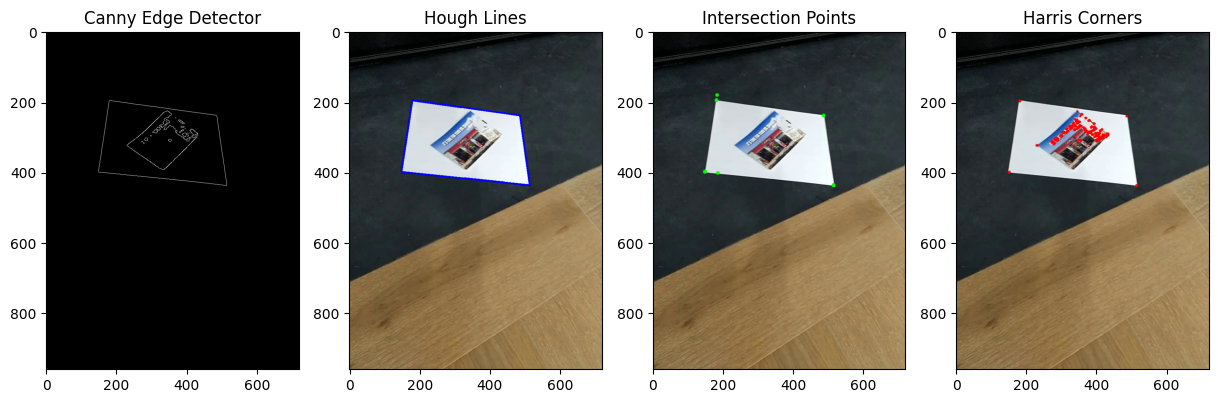

In [ ]:
while(True):
	ret, frame = video_capture.read()

	if not ret:
		break

	token = token+1

  #line frame
	line_frame = np.copy(frame)

  #intersection frame
	intersection_frame = np.copy(frame)

  #Harris Corner frame
	harris_frame = np.copy(frame)


  # Converting to grayscale
	gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

  # Variance of Laplace

  # Laplacian kernel
	kernel_1 = np.array([[0, 1, 0],
					[1, -4, 1],
					[0, 1, 0]])

  # Perform convolution between gray_frame and laplacian kernel
	laplace_result = convolve2d(gray_frame, kernel_1, mode='same', boundary='symm')

  # Calculate the mean of the Laplace result
	laplace_mean = np.mean(laplace_result)

  # Calculate the variance manually
	variance_sum = np.sum((laplace_result - laplace_mean)**2)
	variance = variance_sum / laplace_result.size

  # Removing blurry frames
	if variance < 120:
		blurry_frames_removed += 1
		continue

  # Thresholding to segment out background
	thresholded = np.where(gray_frame < 200, 0, 255).astype(np.uint8)

	# Perform morphological operations (erosion and dilation) to increase the contrast between black and white region
	kernel_2 = np.ones((3,3),np.uint8)
	thresholded = cv2.erode(thresholded, kernel_2, iterations=1)
	thresholded = cv2.dilate(thresholded, kernel_2, iterations=1)


  # Detect edges pixels using Canny edge detector
	edges = cv2.Canny(thresholded, 800, 900)

  # Perform Hough Transform to extract straight lines
	lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=20, minLineLength=103, maxLineGap=8)

	if lines is not None:

		#plotting lines
		for line in lines:
			x1, y1, x2, y2 = line[0]
			cv2.line(frame, (x1, y1), (x2, y2), (255, 0, 0), 4)
			cv2.line(line_frame, (x1, y1), (x2, y2), (255, 0, 0), 4)




		# find intersection points
		intersection_list =[]

		for i in range(len(lines)-1):

			for j in range(i + 1, len(lines)):

				line1 = lines[i][0]
				line2 = lines[j][0]

        # Extract coordinates of line segments
				x1, y1, x2, y2 = line1
				x3, y3, x4, y4 = line2

				# Calculate slopes and intercepts of lines
				if (x2 - x1) != 0:
					slope1 = (y2 - y1) / (x2 - x1)
				else:
					float('inf')

				if (x4 - x3) != 0:
					slope2 = (y4 - y3) / (x4 - x3)
				else:
					float('inf')

				intercept1 = y1 - slope1 * x1
				intercept2 = y3 - slope2 * x3

				# Calculate intersection point
				if slope1 != slope2:  # Lines are not parallel
					intersection_x = (intercept2 - intercept1) / (slope1 - slope2)
					intersection_y = slope1 * intersection_x + intercept1

          # Convert intersection point to integer coordinates
					intersection_x = int(intersection_x)
					intersection_y = int(intersection_y)

          # Storing the intersection points in a list
					intersection_list.append((intersection_x,intersection_y))

					cv2.circle(intersection_frame, (intersection_x, intersection_y), 5, (0, 255, 0), -1)
					# plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))


		# Harris Corner Detection
		# Verify corners using Harris corner detector
    #Filter out the noise
		thresholded = cv2.GaussianBlur(thresholded, (3,3), 3)

		thresholded	= np.float32(thresholded)

    #Finding the corner values
		corners = cv2.cornerHarris(thresholded,2,3,0.04)

    #Coordinates of dominant corner
		dom_corner = np.where(corners > 0.01 * corners.max())
		# Coordinates tuple
		dom_corner_tup = zip(dom_corner[1],dom_corner[0])

		for corner in dom_corner_tup:
			x, y = corner
			cv2.circle(harris_frame, (x, y), 3, (0, 0, 255), -1)


		#Filter out remaining extraneous corners
		filtered_corners = []
		radius = 5
		for corner in dom_corner_tup:
      #Coordinates of harris corners
			x, y = corner
			for intersection in intersection_list:
        #Coordinates of intersection points
				inter_x, inter_y = intersection
				if np.sqrt((x - inter_x)**2 + (y - inter_y)**2) < radius:
          #Storing the filtered harris corners
					filtered_corners.append(corner)
					break

		#Displaying the filtered corners on frame
		for corner in filtered_corners:
			x, y = corner
			cv2.circle(frame, (x, y), 5, (0, 0, 255), -1)


  # Writing the frame to the output video.
	out.write(frame)

	#Diplay images
	plt.figure(figsize=(15,5))

 #Canny edge detector
	plt.subplot(1,4,1)
	plt.imshow(cv2.cvtColor(edges,cv2.COLOR_BGR2RGB))
	plt.title("Canny Edge Detector")

 #Hough lines
	plt.subplot(1,4,2)
	plt.imshow(cv2.cvtColor(line_frame,cv2.COLOR_BGR2RGB))
	plt.title("Hough Lines")

 #Intersection Points
	plt.subplot(1,4,3)
	plt.imshow(cv2.cvtColor(intersection_frame,cv2.COLOR_BGR2RGB))
	plt.title("Intersection Points")

 #Harris Corners
	plt.subplot(1,4,4)
	plt.imshow(cv2.cvtColor(harris_frame,cv2.COLOR_BGR2RGB))
	plt.title("Harris Corners")

#Plotting all the frames
	plt.show()
	clear_output(True)

	ch = cv2.waitKey(1)
	if ch & 0xFF == ord('q'):
		break

video_capture.release()
out.release()
cv2.destroyAllWindows()

### Displaying Video

In [ ]:
import imageio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML

# Function to display the video
def display_video(video):
    fig = plt.figure(figsize=(10,10))

    mov = []
    for i in range(len(video)):
        img = plt.imshow(video[i], animated=True)
        plt.axis('off')
        mov.append([img])

    #Animation creation
    anime = animation.ArtistAnimation(fig, mov, interval=50, repeat_delay=1000)
    plt.close()

    return anime

# Load video
video = imageio.mimread('output_video.mp4', memtest=False)

# Size adjustment (if necessary)
# video = [resize(frame, (256, 256))[..., :3] for frame in video]

# Inline video display in HTML5
HTML(display_video(video).to_html5_video())